In [115]:
# importing libraries
import yfinance as yf
import pandas as pd
import numpy as np
from pycoingecko import CoinGeckoAPI
from alpaca_trade_api.rest import REST
import matplotlib.pyplot as plt

In [ ]:
# Download S&P 500 ETF (SPY) data
api = REST("API KEY", "SECRET KEY", base_url="https://paper-api.alpaca.markets")

spy = api.get_bars("SPY","1D",start="2024-07-21",end="2025-07-20").df


In [117]:
spy = spy[['close']]
spy.rename(columns={"close": "SPY"}, inplace=True)

In [118]:
spy

,SPY
timestamp,
2024-07-22 04:00:00+00:00,554.65
2024-07-23 04:00:00+00:00,553.78
2024-07-24 04:00:00+00:00,541.23
2024-07-25 04:00:00+00:00,538.41
2024-07-26 04:00:00+00:00,544.44
...,...
2025-07-14 04:00:00+00:00,624.81
2025-07-15 04:00:00+00:00,622.14
2025-07-16 04:00:00+00:00,624.22


In [119]:
# Get BTC and ETH  from CoinGecko

cg = CoinGeckoAPI()
btc = cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='usd', days='365')['prices']
eth = cg.get_coin_market_chart_by_id(id='ethereum', vs_currency='usd', days='365')['prices']

In [120]:
btc_df = pd.DataFrame(btc, columns=['timestamp', 'btc_usd'])
eth_df = pd.DataFrame(eth, columns=['timestamp', 'eth_usd'])

btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'], unit='ms')
eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'], unit='ms')
btc_df


,timestamp,btc_usd
0,2024-07-22 00:00:00,68088.139963
1,2024-07-23 00:00:00,67607.713399
2,2024-07-24 00:00:00,65942.417465
3,2024-07-25 00:00:00,65403.535130
4,2024-07-26 00:00:00,65749.963620
...,...,...
361,2025-07-18 00:00:00,119445.365204
362,2025-07-19 00:00:00,117988.946645
363,2025-07-20 00:00:00,117901.626559
364,2025-07-21 00:00:00,117256.920822


In [121]:
# merging btc and eth
crypto_df = pd.merge(btc_df, eth_df, on='timestamp', how='inner').set_index('timestamp')


In [122]:

spy_df = spy.rename(columns={spy.columns[0]:'spy_usd'})
spy_df

crypto_df.index = crypto_df.index.tz_localize(None)
spy_df.index = spy_df.index.tz_localize(None)

crypto_df['date'] = crypto_df.index.date
spy_df['date'] = spy_df.index.date

# Combine all assets
combine_df = pd.merge(spy_df, crypto_df, on='date', how="inner")



In [123]:
combine_df


,spy_usd,date,btc_usd,eth_usd
0,554.65,2024-07-22,68088.139963,3533.118350
1,553.78,2024-07-23,67607.713399,3443.073351
2,541.23,2024-07-24,65942.417465,3482.983771
3,538.41,2024-07-25,65403.535130,3336.380253
4,544.44,2024-07-26,65749.963620,3173.763398
...,...,...,...,...
244,624.81,2025-07-14,119117.556663,2974.265495
245,622.14,2025-07-15,119833.674467,3012.179707
246,624.22,2025-07-16,117678.194934,3133.069858
247,628.04,2025-07-17,118748.162737,3368.126522


In [124]:
combine_df = combine_df[['date', 'spy_usd', 'btc_usd', 'eth_usd']]
combine_df.to_csv("/Users/parthaggarwal/Desktop/Quant_Learning/Projects/Intraday volatility surface/datasets/crypto_SPY.csv")
combine_df

,date,spy_usd,btc_usd,eth_usd
0,2024-07-22,554.65,68088.139963,3533.118350
1,2024-07-23,553.78,67607.713399,3443.073351
2,2024-07-24,541.23,65942.417465,3482.983771
3,2024-07-25,538.41,65403.535130,3336.380253
4,2024-07-26,544.44,65749.963620,3173.763398
...,...,...,...,...
244,2025-07-14,624.81,119117.556663,2974.265495
245,2025-07-15,622.14,119833.674467,3012.179707
246,2025-07-16,624.22,117678.194934,3133.069858
247,2025-07-17,628.04,118748.162737,3368.126522


In [125]:
# compute daily returns
cal = combine_df[['spy_usd', 'btc_usd', 'eth_usd']].copy()
returns = cal.pct_change().dropna()

In [126]:
# cumulative returns
cumulative = (1+returns).cumprod()

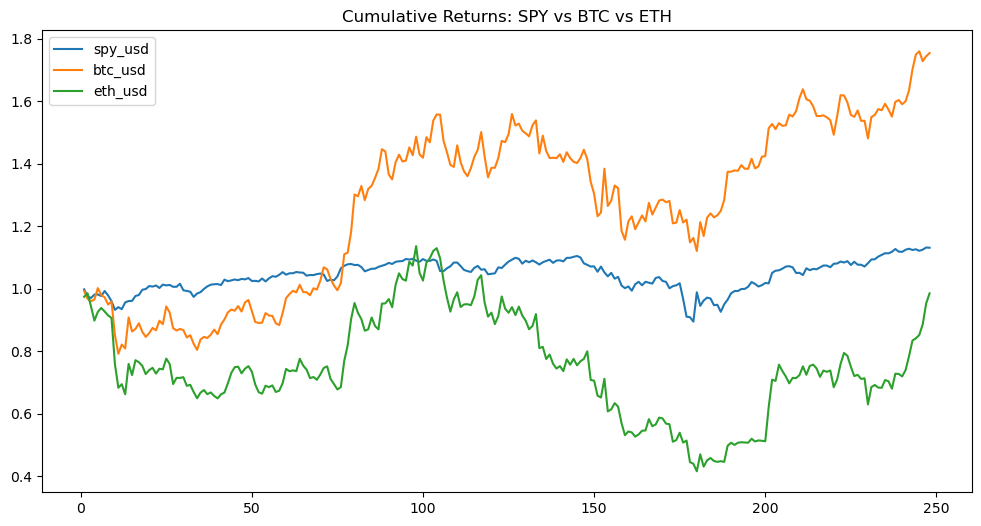

In [127]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(cumulative)
plt.title('Cumulative Returns: SPY vs BTC vs ETH')
plt.legend(cumulative.columns)
plt.ion()
plt.show()


In [128]:
rolling_vol = returns.rolling(30, min_periods=20).std()*(252**0.5)
rolling_vol

,spy_usd,btc_usd,eth_usd
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
...,...,...,...
244,0.092455,0.348709,0.704396
245,0.093800,0.341881,0.702024
246,0.093224,0.347782,0.697625
247,0.093386,0.348049,0.722198


In [129]:
rolling_avg = returns.rolling(30, min_periods=20).mean()
rolling_avg

,spy_usd,btc_usd,eth_usd
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
...,...,...,...
244,0.001926,0.003553,0.004486
245,0.001821,0.004400,0.005448
246,0.001745,0.003812,0.007986
247,0.001759,0.004060,0.009549


In [130]:
# prepare result containers
drawdown_stats = {}

# loop over each asset column in combined_df
for col in ['spy_usd', 'btc_usd', 'eth_usd']:
    price_series = combine_df[col].dropna()

    # compute running max and drawdown
    running_max = price_series.cummax()
    drawdown = (price_series - running_max)/running_max

    # max drawdown
    max_dd = drawdown.min()

    # drawdown duration
    drawdown_flag = drawdown < 0
    dd_durations = (drawdown_flag.astype(int).groupby((~drawdown_flag).cumsum()).cumsum())
    max_dd_duration = dd_durations.max()

    # store results
    drawdown_stats[col] = {'max_drawdown_pct': round(max_dd * 100, 2),
                        'max_drawdown_duration_days': int(max_dd_duration)
                        }

# convert to dataframe for better readability
drawdown_df = pd.DataFrame(drawdown_stats).T
print(drawdown_df)



         max_drawdown_pct  max_drawdown_duration_days
spy_usd            -19.00                        88.0
btc_usd            -28.12                        82.0
eth_usd            -63.36                       150.0


In [131]:
log_cal = np.log(cal)

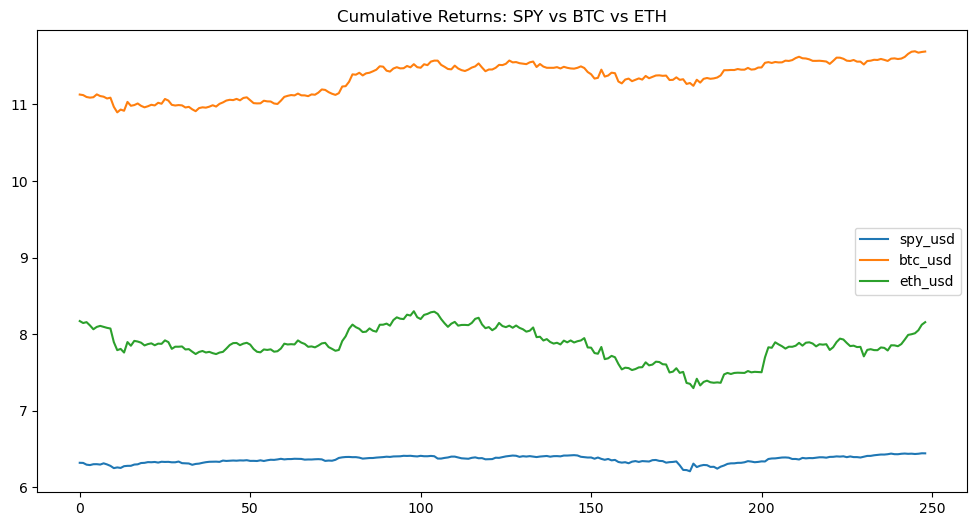

In [132]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(log_cal)
plt.title('Cumulative Returns: SPY vs BTC vs ETH')
plt.legend(cal.columns)
plt.ion()
plt.show()

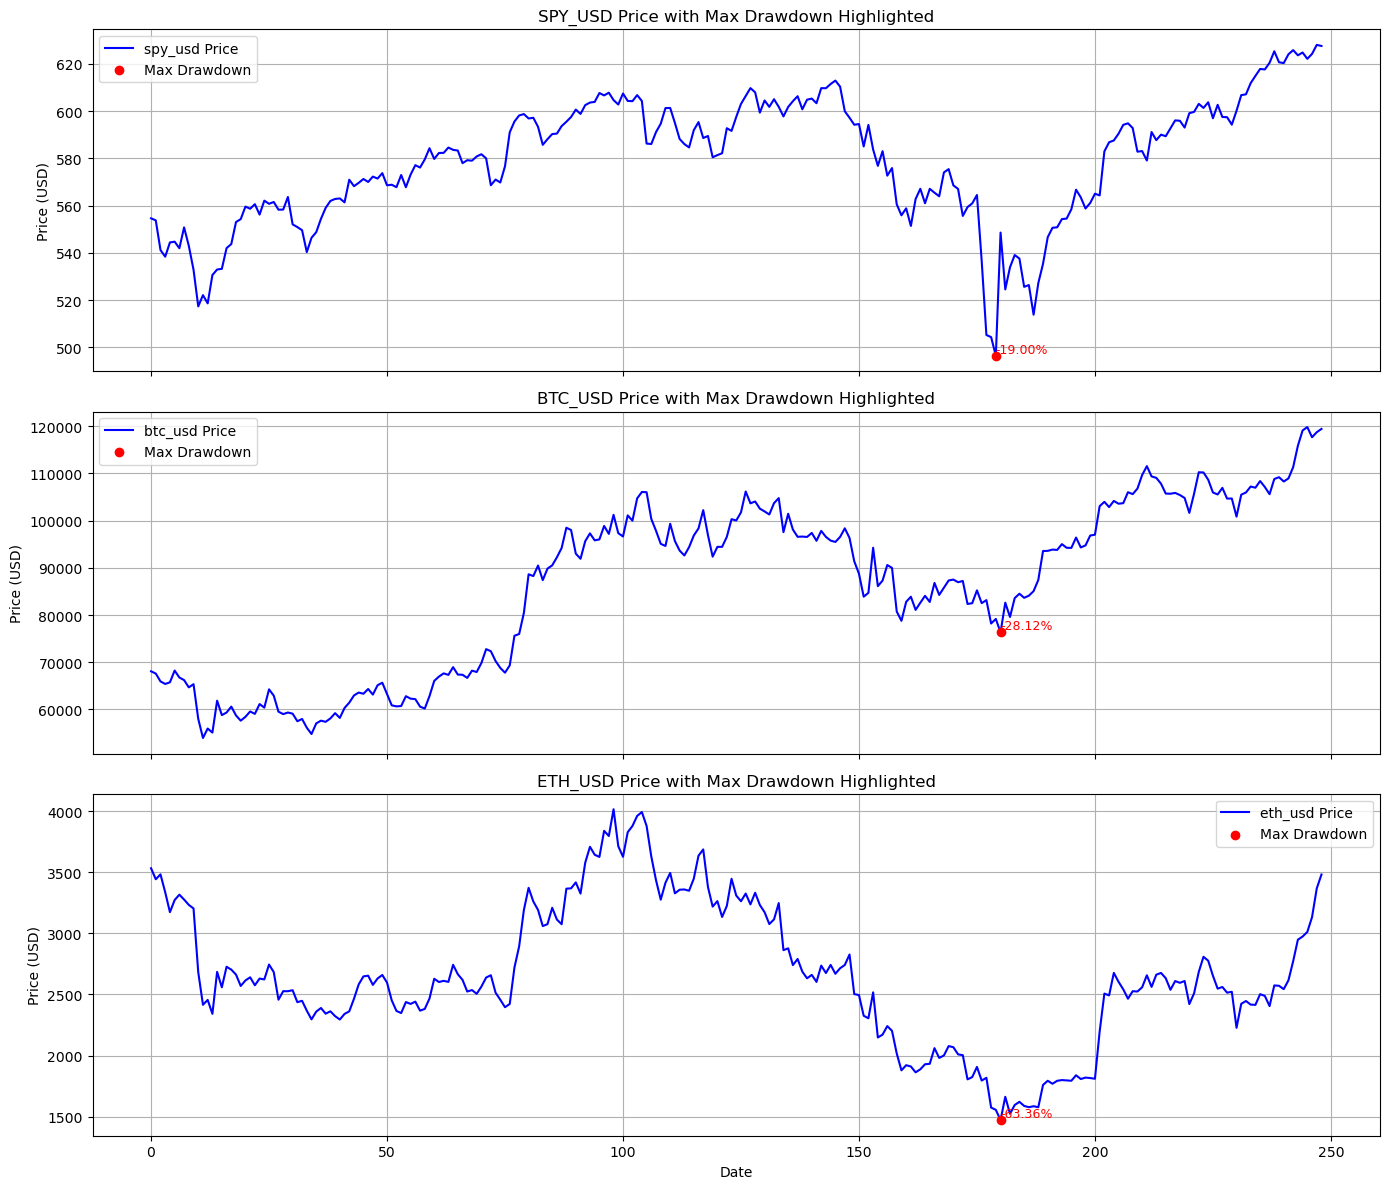

In [133]:


# Set up the figure
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Loop over assets
assets = ['spy_usd', 'btc_usd', 'eth_usd']

for i, col in enumerate(assets):
    price = combine_df[col].dropna()
    
    # Calculate running max and drawdown
    running_max = price.cummax() # 
    drawdown = (price - running_max) / running_max
    
    # Find max drawdown point
    max_dd_idx = drawdown.idxmin()
    max_dd_val = price.loc[max_dd_idx]
    
    # Plot price
    ax[i].plot(price.index, price, label=f'{col} Price', color='blue')
    
    # Plot max drawdown point
    ax[i].scatter(max_dd_idx, max_dd_val, color='red', zorder=5, label='Max Drawdown')
    ax[i].text(max_dd_idx, max_dd_val, f'{drawdown.min():.2%}', 
               verticalalignment='bottom', color='red', fontsize=9)
    
    # Title and formatting
    ax[i].set_title(f'{col.upper()} Price with Max Drawdown Highlighted')
    ax[i].set_ylabel('Price (USD)')
    ax[i].legend()
    ax[i].grid(True)

# Shared x-axis label
ax[-1].set_xlabel('Date')

plt.tight_layout()
plt.show()


In [138]:
normalized_df = cal / cal.iloc[0]
normalized_df

,spy_usd,btc_usd,eth_usd
0,1.000000,1.000000,1.000000
1,0.998431,0.992944,0.974514
2,0.975805,0.968486,0.985810
3,0.970720,0.960572,0.944316
4,0.981592,0.965660,0.898290
...,...,...,...
244,1.126494,1.749461,0.841824
245,1.121680,1.759979,0.852556
246,1.125430,1.728321,0.886772
247,1.132318,1.744036,0.953301


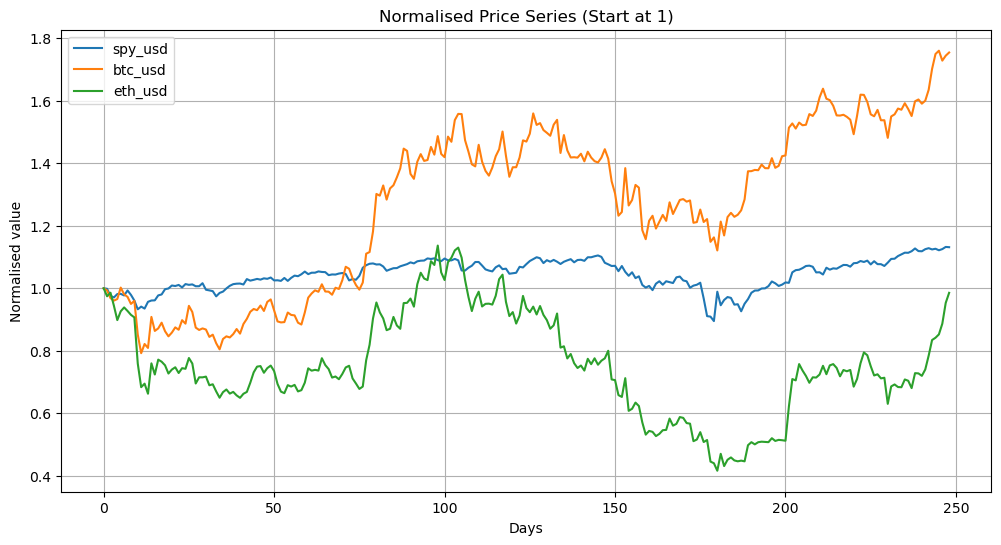

In [139]:
plt.figure(figsize=(12,6))
for col in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df[col], label=col)

plt.title("Normalised Price Series (Start at 1)")
plt.xlabel('Days')
plt.ylabel('Normalised value')
plt.legend()
plt.grid(True)
plt.show()



In [146]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, acf, pacf
for asset in returns.columns:
    adf_results = adfuller(returns[asset])
    print("ADF Test Statistic:", adf_results[0])
    print("p-value:", adf_results[1])


ADF Test Statistic: -9.845902113841912
p-value: 4.620656131795938e-17
ADF Test Statistic: -16.63928102295665
p-value: 1.640029439364735e-29
ADF Test Statistic: -15.562493792004602
p-value: 2.0341588024215803e-28


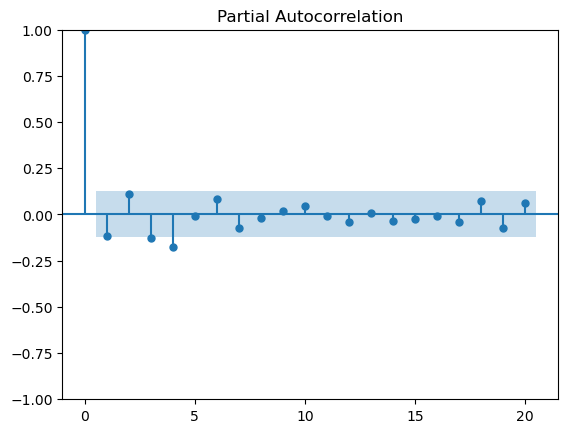

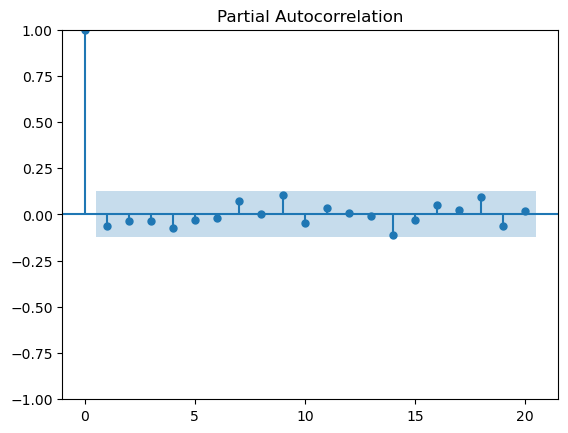

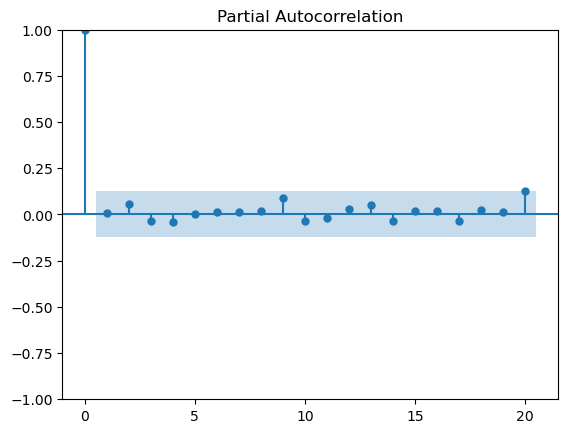

In [151]:
from statsmodels.graphics.tsaplots import plot_pacf
for a in returns.columns:
    plot_pacf(returns[a], lags =20)
plt.show()

In [154]:


for assets in returns.columns:
    series = returns[assets].dropna()
    model = AutoReg(series, lags=5, old_names=False)
    result = model.fit()
    print(f'---n === {assets} ===')
    print(result.summary())




---n === spy_usd ===
                            AutoReg Model Results                             
Dep. Variable:                spy_usd   No. Observations:                  248
Model:                     AutoReg(5)   Log Likelihood                 721.372
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Mon, 21 Jul 2025   AIC                          -1428.744
Time:                        11:00:41   BIC                          -1404.293
Sample:                             5   HQIC                         -1418.895
                                  248                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.063      0.288      -0.001       0.002
spy_usd.L1    -0.1141      0.064     -1.779      0.075      -0.240       0.012
spy_usd.L2     0.1240      0.06

/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [168]:
from statsmodels.stats.diagnostic import acorr_ljungbox
for assets in returns.columns:
    series = returns[assets].dropna()
    lb_result = acorr_ljungbox(series, lags=[1], return_df=True)
    print(f'\nljungbox for {assets}')
    print(lb_result)


ljungbox for spy_usd
    lb_stat  lb_pvalue
1  3.322484   0.068338

ljungbox for btc_usd
    lb_stat  lb_pvalue
1  0.930424   0.334753

ljungbox for eth_usd
    lb_stat  lb_pvalue
1  0.007374   0.931569
